In [ ]:
from scipy.io import loadmat
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pascal50s_mat = loadmat('/content/drive/MyDrive/DL_proj/pascal50S.mat')

In [ ]:
pascal50s_mat['train_sent_final'][0][731][0][0]

'https://filebox.ece.vt.edu/~vrama91/PASCAL/2008_007323.jpg'

In [ ]:
images_array=[]
image_shape=[]
def image_read():
  for i in tqdm(range(1000)):
    image = str(pascal50s_mat['train_sent_final'][0][i][0][0])
    image_numpy = io.imread( image )
    images_array.append(image_numpy)
    image_shape.append(image_numpy.shape)

In [ ]:
image_read()

100%|██████████| 1000/1000 [01:58<00:00,  8.43it/s]


#Task 1



In [ ]:
import os
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#preprocessing text data by converting into lower case,removing punctuation and removing numbers

def preprocess(caption):
  cap_temp=[]
  caption=[word.lower() for word in caption.split()]
  for c in caption:
    table=c.maketrans('' ,'',string.punctuation)
    wrd=c.translate(table)
    cap_temp.append(wrd)
  caption=[word+" " for word in cap_temp if word.isalpha()]
  caption=''.join(caption)
  return caption

In [ ]:
stemmer=nltk.SnowballStemmer('english')  #stemmer object to convert all words to their root form

In [ ]:
cap_list=[]
stop_words = set(stopwords.words('english')) 
for i in range(1000):
  temp_cap=[]
  for j in range(50):
    caption=pascal50s_mat['train_sent_final'][0][i][1][0][j][0]
    caption=preprocess(caption)
    word_tokens = word_tokenize(caption) 
    temp_cap.append([stemmer.stem(w) for w in word_tokens if not w in stop_words])
  cap_list.append(temp_cap)  #now cap_list contain captions without stopwords

In [ ]:
l = ['person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train', 'bottle', 'chair','dining table', 'potted plant', 'sofa', 'monitor']
syn=[['person','man','men','peopl','friend','woman','women','famili','friend','girl','bicyclist','rider','someone','jockey','motorcyclist','guy','babi','boy','cyclist'],['bird','hen','eagl','chicken','chick','duck','goos','ostrich','owl','seagul'],['cat','kitten'],['cow','calf','bull','graze','anim'],['dog','pug'],['horse','hors'],['sheep','lamb','goat'],['aeroplane','jet','aircraft','plane','airplan'],['bicycl','cycle','motorcycl','bicyclist','cyclist'],['boat','ship','cano'],['bus','buse'],['car','taxi','toyota','truck','limo','van','jeep'],['motorbik','bike','scooter','mope'],['train','engine'],['bottl','vase','drink'],['chair'],['dine','tabl'],['plant','pot','garden'],['sofa','couch','live'],['tv','televis','monitor','comput','laptop']]

#l is the list of 20 classes or labels for classification
#syn contains the synonyms corresponding to each label 

In [ ]:
syn_dict={}               #a dict with labels as keys and their synonyms list as values
for i in range(20):
  syn_dict[l[i]]=syn[i]

In [ ]:
labels={x:list() for x in range(1000)}
def assign_labels():                      #function to assign labels for each of the 1000 images
  for i in range(1000):
    temp=[]
    for j in range(50):
      for x in range(len(cap_list[i][j])):
        for k in range(20):
          if(cap_list[i][j][x] in syn_dict[l[k]]):
            cap_list[i][j][x] = l[k]
            break
      temp+=cap_list[i][j]
    count_list=Counter(temp).most_common(10)
    for item in count_list:
        if (item[0] in l and item[0] not in labels[i]):
          labels[i].append(item[0])     

In [ ]:
assign_labels()

In [ ]:
#function to assign labels to those images which weren't assigned any label by the assign_labels() function
def assign_missing_labels():
  missing_labels=[['car'],['chair'],['car'],['bottle'],['chair'],['chair'],['dog'],['monitor'],['car'],['bottle','chair'],['monitor','chair'],['car'],['car'],['monitor']]
  k=0
  for i in range(1000):
    if(labels[i]==[]):
      labels[i]=missing_labels[k]
      k+=1

In [ ]:
assign_missing_labels()

In [ ]:
resized_imgs=np.array([np.resize(images_array[i],(299,299,3)) for i in range(len(images_array))])  #converting all images to the same shape

In [ ]:
def create_tag_mapping(label):
	# order alphabetically
	label.sort()
	# dict that maps labels to integers, and the reverse
	labels_map = {label[i]:i for i in range(len(label))}
	inv_labels_map = {i:label[i] for i in range(len(label))}
	return labels_map, inv_labels_map

In [ ]:
lab_map,inv_map1=create_tag_mapping(l)

In [ ]:
lab_map

{'aeroplane': 0,
 'bicycle': 1,
 'bird': 2,
 'boat': 3,
 'bottle': 4,
 'bus': 5,
 'car': 6,
 'cat': 7,
 'chair': 8,
 'cow': 9,
 'dining table': 10,
 'dog': 11,
 'horse': 12,
 'monitor': 13,
 'motorbike': 14,
 'person': 15,
 'potted plant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19}

In [ ]:
def one_hot_encode(labels):
  ohe_labels=[]
  for i in labels:
    temp=np.zeros(20)
    for j in labels[i]:
      temp[lab_map[j]]=1
    ohe_labels.append(temp)
  return np.array(ohe_labels).reshape(len(labels),20)

In [ ]:
ohe_labels=one_hot_encode(labels)
ohe_labels.shape

(1000, 20)

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras import backend,Sequential
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.preprocessing import LabelEncoder
from keras.applications import ResNet50
from keras.utils import to_categorical
from keras.layers import Dense, Flatten,Input, Conv2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional,BatchNormalization, Activation, RepeatVector,Concatenate,MaxPool2D,Dropout,AveragePooling2D
import cv2
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score

In [ ]:
train_X,test_X,train_Y,test_Y=train_test_split(resized_imgs,ohe_labels,test_size=0.02)

In [ ]:
train_X = train_X/255
test_X = test_X/255

Inceptionv3 model

In [ ]:
inc_model=InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inc_model.layers:
  layer.trainable=False

In [ ]:
inc_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
def create_model():
  model = keras.models.Sequential()
  model.add(inc_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(128, activation='relu'))
  model.add(keras.layers.Dense(20, activation='sigmoid'))
  return model

In [ ]:
model_ = create_model()

In [ ]:
model_.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 131072)            524288    
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2

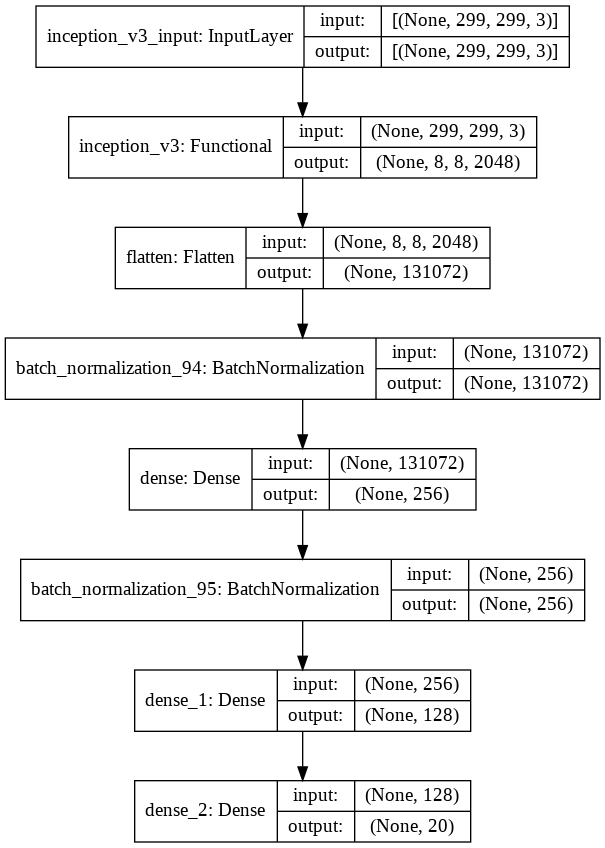

In [ ]:
from keras.utils import plot_model
plot_model(model_,show_shapes=True)

In [ ]:
trainAug = ImageDataGenerator(rotation_range=15, zoom_range=0.2,fill_mode="nearest")

In [ ]:
model_ = create_model()
model_.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_.fit(trainAug.flow(train_X, train_Y),epochs=50)

Epoch 1/50
31/31 [==============================] - 55s 571ms/step - loss: 0.5521 - accuracy: 0.0977
Epoch 2/50
31/31 [==============================] - 17s 554ms/step - loss: 0.2609 - accuracy: 0.1221
Epoch 3/50
31/31 [==============================] - 17s 554ms/step - loss: 0.2411 - accuracy: 0.1506
Epoch 4/50
31/31 [==============================] - 17s 556ms/step - loss: 0.2349 - accuracy: 0.1853
Epoch 5/50
31/31 [==============================] - 17s 556ms/step - loss: 0.2267 - accuracy: 0.2043
Epoch 6/50
31/31 [==============================] - 17s 558ms/step - loss: 0.2113 - accuracy: 0.2158
Epoch 7/50
31/31 [==============================] - 17s 560ms/step - loss: 0.2030 - accuracy: 0.2475
Epoch 8/50
31/31 [==============================] - 17s 561ms/step - loss: 0.1974 - accuracy: 0.2510
Epoch 9/50
31/31 [==============================] - 17s 559ms/step - loss: 0.1850 - accuracy: 0.3021
Epoch 10/50
31/31 [==============================] - 18s 566ms/step - loss: 0.1703 - accura

In [ ]:
model_.save('/content/drive/MyDrive/model1_DL.h5')

In [ ]:
ypred=model_.predict(test_X)
ypred_rounded=backend.round(backend.clip(ypred, 0, 1))

In [ ]:
acc_score=accuracy_score(test_Y,ypred_rounded)
print("Accuracy on test data is : ",acc_score)

Accuracy on test data is :  0.1


In [ ]:
f_score=fbeta_score(test_Y,ypred_rounded,0.2,average='micro')
print('fbeta_score on test dataset is :',f_score)

fbeta_score on test dataset is : 0.47852760736196315


In [ ]:
for j in range(12,15):
    pred_label=[inv_map1[i] for i in inv_map1 if ypred_rounded[j][i]==1]
    true_label=[inv_map1[i] for i in inv_map1 if test_Y[j][i]==1]
    print("True label : ",true_label)
    print("Predicted label : ",pred_label)

True label :  ['bus']
Predicted label :  ['bus']
True label :  ['car', 'person']
Predicted label :  ['person']
True label :  ['dining table', 'person', 'potted plant']
Predicted label :  ['person']


-------

#Task 2

In [ ]:
res_model = ResNet50(include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
final2 = res_model.layers[-2].output
model2 = Model(inputs = res_model.input,outputs = final2)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
train_images_features_2 = {}
test_images_features_2={}

def features():
  for i in range(1000):
      img=images_array[i]
      img = cv2.resize(img, (224,224))    
      img = img.reshape(1,224,224,3)
      pred = model2.predict(img).reshape(2048,)  
      if(i<980):
        train_images_features_2[i] = pred
      else:
        test_images_features_2[i-980]=pred
    


In [ ]:
features()

In [ ]:
train_images_features_3=train_images_features_2
train_images_f_2 = list(train_images_features_2)
train_images_f_3=train_images_f_2

test_images_features_3=test_images_features_2
test_images_f_2=list(test_images_features_2)
test_images_f_3=test_images_f_2


In [ ]:
train_cap_lis_2 = []
test_cap_lis_2 = []

for j in range(1000):
  for i in range(10):
    pascal50s_mat['train_sent_final'][0][j][1][0][i][0] = pascal50s_mat['train_sent_final'][0][j][1][0][i][0].replace(".","")
    if(j<980):
      train_cap_lis_2.append("start "+pascal50s_mat['train_sent_final'][0][j][1][0][i][0].lower() +" end")
    else:
      test_cap_lis_2.append("start "+pascal50s_mat['train_sent_final'][0][j][1][0][i][0].lower() +" end")
    
train_cap_lis_3=train_cap_lis_2
test_cap_lis_3=test_cap_lis_2

In [ ]:
tokenizer_2 = Tokenizer(3910)
tokenizer_2.fit_on_texts(train_cap_lis_2+train_cap_lis_2)
train_sequences_2 = tokenizer_2.texts_to_sequences(train_cap_lis_2)
test_sequences_2=tokenizer_2.texts_to_sequences(test_cap_lis_2)

tokenizer_3=tokenizer_2
train_sequences_3=train_sequences_2
test_sequences_3=test_sequences_2

In [ ]:
i=0
train_new_list_2=[]
while i<len(train_sequences_2):
  train_new_list_2.append(train_sequences_2[i:i+10])
  i+=10
train_new_list_3=train_new_list_2

i=0
test_new_list_2=[]
while i<len(test_sequences_2):
  test_new_list_2.append(test_sequences_2[i:i+10])
  i+=10
test_new_list_3=test_new_list_2

In [ ]:
tk_2 = tokenizer_2.word_index

tk_3=tk_2

In [ ]:
print(tk_2)

{'a': 1, 'end': 2, 'start': 3, 'the': 4, 'on': 5, 'in': 6, 'is': 7, 'of': 8, 'with': 9, 'and': 10, 'two': 11, 'at': 12, 'are': 13, 'man': 14, 'an': 15, 'sitting': 16, 'to': 17, 'dog': 18, 'people': 19, 'cat': 20, 'room': 21, 'woman': 22, 'white': 23, 'train': 24, 'table': 25, 'standing': 26, 'bus': 27, 'parked': 28, 'horse': 29, 'black': 30, 'small': 31, 'for': 32, 'his': 33, 'sheep': 34, 'couch': 35, 'front': 36, 'down': 37, 'by': 38, 'field': 39, 'car': 40, 'sits': 41, 'next': 42, 'looking': 43, 'camera': 44, 'up': 45, 'group': 46, 'some': 47, 'bike': 48, 'grass': 49, 'posing': 50, 'water': 51, 'living': 52, 'riding': 53, 'bird': 54, 'girl': 55, 'it': 56, 'near': 57, 'young': 58, 'baby': 59, 'out': 60, 'red': 61, 'men': 62, 'her': 63, 'boat': 64, 'women': 65, 'plane': 66, 'motorcycle': 67, 'cows': 68, 'blue': 69, 'cow': 70, 'chair': 71, 'road': 72, 'computer': 73, 'large': 74, 'street': 75, 'outside': 76, 'three': 77, 'has': 78, 'through': 79, 'picture': 80, 'green': 81, 'tracks': 82

In [ ]:
def maxlen(seq):
  m=0
  k=0
  for r in range(len(seq)):
    n= len(seq[r])
    if n>m:
      max_len=n
  return max_len

In [ ]:
m1=maxlen(train_sequences_2)
m2=maxlen(test_sequences_2)
max_len_2=max(m1,m2)

max_len_3=max_len_2

In [ ]:
train_captions_dict_2 = {}
test_captions_dict_2={}
for c in range(1000):
  if(c<980):
    train_captions_dict_2[train_images_f_2[c]] = train_new_list_2[c]
  else:
    test_captions_dict_2[test_images_f_2[c-980]] = test_new_list_2[c-980]

train_captions_dict_3=train_captions_dict_2
test_captions_dict_3=test_captions_dict_2

In [ ]:
VOCAB_SIZE = len(tk_2)+1

def generator_2(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out_2 = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=max_len_2, padding='post', truncating='post')[0]
                y_out_2.append(ohe_labels[k])
                y_in.append(in_seq)
            
    return X, y_in,y_out_2

In [ ]:
train_X_2,train_y_in_2,train_y_out_2 = generator_2(train_images_features_2, train_captions_dict_2)

train_X_2 = np.array(train_X_2)
train_y_in_2 = np.array(train_y_in_2, dtype='float64')
train_y_out_2 = np.array(train_y_out_2, dtype='float64')

In [ ]:
embedding_size = 128
VOCAB_SIZE = 3906
max_len_2=15
def embedded_model():
    image_model = Sequential()

    image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
    image_model.add(RepeatVector(max_len_2))

    image_model.summary()

    language_model = Sequential()

    language_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_size, input_length=max_len_2))
    language_model.add(LSTM(256, return_sequences=True))
    language_model.add(TimeDistributed(Dense(embedding_size)))

    language_model.summary()

    concat_model = Concatenate()([image_model.output, language_model.output])
    x=Flatten()(concat_model)
    x=BatchNormalization()(x)
    x=Dense(256, activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dense(128, activation='relu')(x)
    out=Dense(20, activation='sigmoid')(x)

    model = Model(inputs=[image_model.input, language_model.input], outputs = out)
    model.summary()
    return model

In [ ]:
model_2 = embedded_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 128)           499968    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 128)           32896     
Total params: 927,104
Trai

In [ ]:
model_2 = embedded_model()

model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               262272    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 15, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 15, 128)           495616    
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 256)           394240    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 128)           32896     
Total params: 922,752
Tr

In [ ]:
model_2.fit([train_X_2, train_y_in_2], train_y_out_2, batch_size=128, epochs=50)

Epoch 1/50
744/744 [==============================] - 12s 13ms/step - loss: 0.0629 - accuracy: 0.5924
Epoch 2/50
744/744 [==============================] - 10s 13ms/step - loss: 1.2947e-04 - accuracy: 0.6372
Epoch 3/50
744/744 [==============================] - 10s 13ms/step - loss: 3.5150e-04 - accuracy: 0.6348
Epoch 4/50
744/744 [==============================] - 10s 13ms/step - loss: 9.1396e-04 - accuracy: 0.6623
Epoch 5/50
744/744 [==============================] - 10s 13ms/step - loss: 4.7632e-05 - accuracy: 0.6553
Epoch 6/50
744/744 [==============================] - 10s 13ms/step - loss: 1.9190e-05 - accuracy: 0.6594
Epoch 7/50
744/744 [==============================] - 10s 13ms/step - loss: 9.6395e-06 - accuracy: 0.6596
Epoch 8/50
744/744 [==============================] - 10s 13ms/step - loss: 5.6195e-06 - accuracy: 0.6563
Epoch 9/50
744/744 [==============================] - 10s 13ms/step - loss: 3.6831e-06 - accuracy: 0.6523
Epoch 10/50
744/744 [=============================

In [ ]:
test_X_2,test_y_in_2,test_y_out_2=generator_2(test_images_features_2,test_captions_dict_2)

test_X_2 = np.array(test_X_2)
test_y_in_2 = np.array(test_y_in_2, dtype='float64')
test_y_out_2 = np.array(test_y_out_2, dtype='float64')



In [ ]:
ypred_rounded=[]
def predict_2():
  for i in range(0,400,100):
    y_pred=model_2.predict([test_X_2[i].reshape(1,2048),test_y_in_2[i].reshape(1,15)])
    ypred_rounded.append(backend.round(backend.clip(y_pred, 0, 1)))
    pred_label=[inv_map1[k] for k in inv_map1 if y_pred[0][k]==1]
    
    for k,j in test_images_features_2.items():
      if(list(j)==list(test_X_2[i])):
        true_label=labels[980+k]
        plt.imshow(images_array[980+k])
        plt.show()
    print("True label : ",true_label)
    print("Predicted label : ",pred_label)
    print()

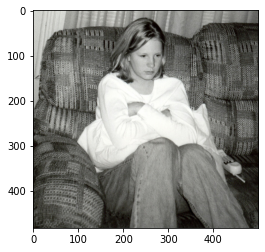

True label :  ['person', 'sofa']
Predicted label :  ['person', 'sofa']



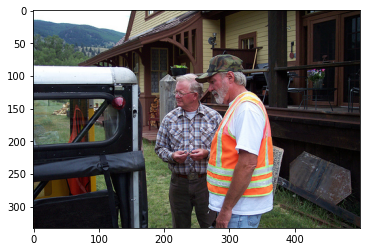

True label :  ['person', 'car']
Predicted label :  []



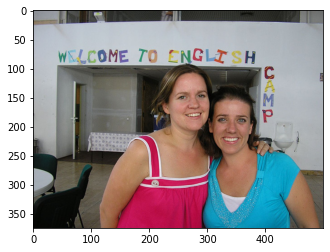

True label :  ['person']
Predicted label :  ['person']



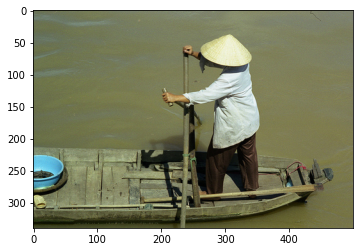

True label :  ['person', 'boat']
Predicted label :  ['person']



In [ ]:
predict_2()

_________________

#Task 3

In [ ]:
res_model = ResNet50(include_top=True)

In [ ]:
final3 = res_model.layers[-2].output
model3 = Model(inputs = res_model.input,outputs = final3)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
VOCAB_SIZE = len(tk_3)+1

def generator_3(photo, caption):
    n_samples = 0    
    X = []
    y_in = []
    y_out = []    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=max_len_3, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)            
    return X, y_in, y_out

In [ ]:
train_X_3, train_y_in_3, train_y_out_3 = generator_3(train_images_features_3, train_captions_dict_3)

In [ ]:
train_X_3 = np.array(train_X_3)
train_y_in_3 = np.array(train_y_in_3, dtype='float64')
train_y_out_3 = np.array(train_y_out_3, dtype='float64')

In [ ]:
image_model = Sequential()

image_model.add(Dense(128, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len_3))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=max_len_3))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(128)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(VOCAB_SIZE)(x)
out = Activation('softmax')(x)
model_3 = Model(inputs=[image_model.input, language_model.input], outputs = out)

model_3.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 128)           495616    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 128)           32896     
Total params: 922,752
Trai

In [ ]:
model_3.fit([train_X_3, train_y_in_3], train_y_out_3, batch_size=512, epochs=50)

Epoch 1/50
186/186 [==============================] - 13s 46ms/step - loss: 5.4422 - accuracy: 0.1706
Epoch 2/50
186/186 [==============================] - 8s 45ms/step - loss: 4.7410 - accuracy: 0.2298
Epoch 3/50
186/186 [==============================] - 8s 45ms/step - loss: 4.5057 - accuracy: 0.2477
Epoch 4/50
186/186 [==============================] - 9s 46ms/step - loss: 4.2380 - accuracy: 0.2664
Epoch 5/50
186/186 [==============================] - 9s 46ms/step - loss: 4.0021 - accuracy: 0.2902
Epoch 6/50
186/186 [==============================] - 8s 46ms/step - loss: 3.7409 - accuracy: 0.3206
Epoch 7/50
186/186 [==============================] - 9s 46ms/step - loss: 3.5471 - accuracy: 0.3429
Epoch 8/50
186/186 [==============================] - 8s 46ms/step - loss: 3.3851 - accuracy: 0.3603
Epoch 9/50
186/186 [==============================] - 9s 46ms/step - loss: 3.2117 - accuracy: 0.3800
Epoch 10/50
186/186 [==============================] - 9s 47ms/step - loss: 3.0988 - accur

In [ ]:
inv_dict = {v:k for k, v in tk_3.items()}

In [ ]:
test_X_3,test_y_in_3,test_y_out_3=generator_3(test_images_features_3,test_captions_dict_3)

test_X_3 = np.array(test_X_3)
test_y_in_3 = np.array(test_y_in_3, dtype='float64')
test_y_out_3 = np.array(test_y_out_3, dtype='float64')

Text(0.5, 0, ' a man in a canoe fishing on the lake')

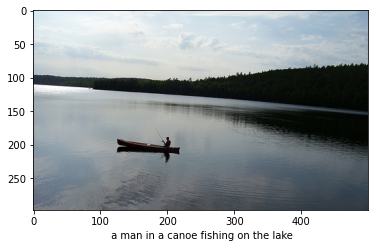

In [ ]:
#predicting the captions of trained images
test_feature = train_X_3[0].reshape(1,2048)
test_img=images_array[0]
text_inp = ['start']

count = 0
caption = ''
while count < 28:
  count += 1
  encoded = []
  for i in text_inp:
    encoded.append(tk_3[i])

  encoded = [encoded]

  encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len_3)
  prediction = np.argmax(model_3.predict([test_feature, encoded]))
  sampled_word = inv_dict[prediction]  
                 
  if sampled_word == 'end':
    break
  caption = caption + ' ' + sampled_word 
  text_inp.append(sampled_word)
plt.figure()
plt.imshow(test_img)
plt.xlabel(caption)

Text(0.5, 0, ' a group of military couples enjoying a dinner table')

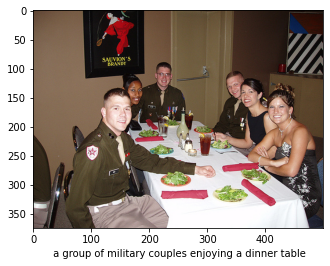

In [ ]:
test_feature = train_X_3[400].reshape(1,2048)
test_img=images_array[4]
text_inp = ['start']

count = 0
caption = ''
while count < 28:
  count += 1
  encoded = []
  for i in text_inp:
    encoded.append(tk_3[i])

  encoded = [encoded]

  encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len_3)
  prediction = np.argmax(model_3.predict([test_feature, encoded]))
  sampled_word = inv_dict[prediction]  
                 
  if sampled_word == 'end':
    break
  caption = caption + ' ' + sampled_word 
  text_inp.append(sampled_word)
plt.figure()
plt.imshow(test_img)
plt.xlabel(caption)

In [ ]:
#predicting the captions of untrained images
def predict_3():
  for i in range(0,400,100):
    for k,j in test_images_features_3.items():
        if(list(j)==list(test_X_3[i])):
          true_cap=pascal50s_mat['train_sent_final'][0][980+k][1][0][0][0]
          plt.imshow(images_array[980+k])
          plt.show()
          break
    text_inp = ['start']

    count = 0
    caption = ''
    while count < max_len_3:
      count += 1
      encoded = []
      for ii in text_inp:
        encoded.append(tk_3[ii])

      encoded = [encoded]

      encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_len_3)
      prediction = np.argmax(model_3.predict([test_X_3[i].reshape(1,2048), encoded]))
      sampled_word = inv_dict[prediction]  
                    
      if sampled_word == 'end':
        break
      caption = caption + ' ' + sampled_word 
      text_inp.append(sampled_word)
    print("original : ",true_cap)
    print("predicted : ",caption)

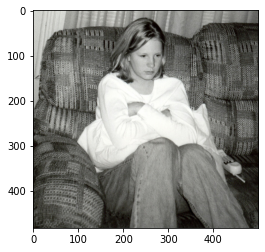

original :  a girl is sitting on the couch and upset
predicted :   a woman and child sitting on a small couch


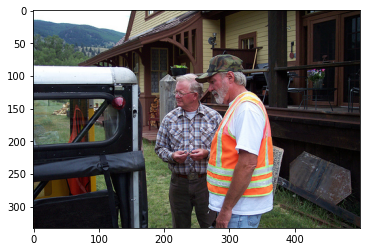

original :  two old men look at the car
predicted :   two people pose with motorcycles on a bus next to a stop


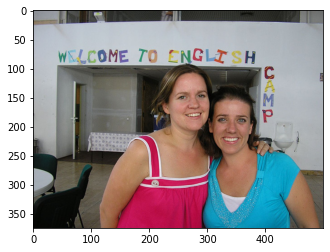

original :  Two friends pose at a english camp
predicted :   a woman poses for a picture with her daughter


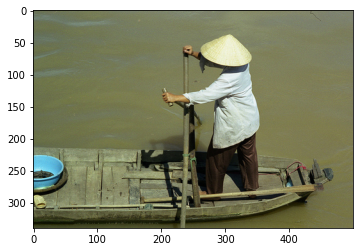

original :  A women is rowing a boat on the river
predicted :   two people are enjoying a table while sign to a blue man


In [ ]:
predict_3()